In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [2]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [7]:
# Useful Constants
TRAIN = "/content/drive/MyDrive/Colab Notebooks/activity_recognition/UCI_HAR_Dataset/train/"
TEST = "/content/drive/MyDrive/Colab Notebooks/activity_recognition/UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [8]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [9]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [10]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

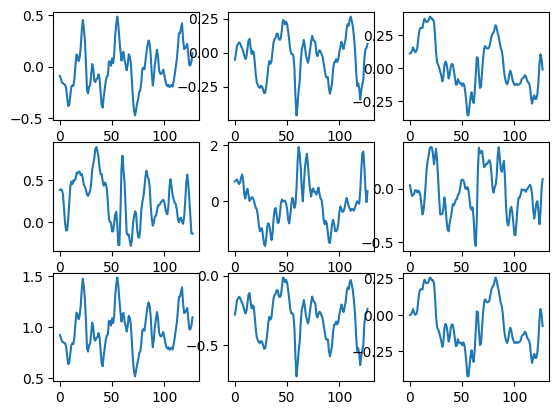

In [11]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()

plot_lines(X_train_per_class[1], 1)

In [12]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [13]:
def performance_plots(model, X_test, Y_test, log, epochs):
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [14]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

### Single Layer SimpleRNN

In [16]:
### START YOUR CODE

# single layer model
model = Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 9)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 6)                 6918      
                                                                 
Total params: 6918 (27.02 KB)
Trainable params: 6918 (27.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
### START YOUR CODE
batch_size = 64
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
115/115 [==============================] - 2s 6ms/step - loss: 1.1921 - accuracy: 0.5397 - val_loss: 1.2610 - val_accuracy: 0.5310
Epoch 2/10
115/115 [==============================] - 0s 4ms/step - loss: 1.0755 - accuracy: 0.5864 - val_loss: 1.2964 - val_accuracy: 0.5154
Epoch 3/10
115/115 [==============================] - 0s 4ms/step - loss: 1.0515 - accuracy: 0.6060 - val_loss: 1.3206 - val_accuracy: 0.5334
Epoch 4/10
115/115 [==============================] - 0s 4ms/step - loss: 1.0402 - accuracy: 0.6253 - val_loss: 1.3373 - val_accuracy: 0.5192
Epoch 5/10
115/115 [==============================] - 0s 4ms/step - loss: 1.0335 - accuracy: 0.6175 - val_loss: 1.3327 - val_accuracy: 0.4985
Epoch 6/10
115/115 [==============================] - 0s 4ms/step - loss: 1.0260 - accuracy: 0.6215 - val_loss: 1.3355 - val_accuracy: 0.5334
Epoch 7/10
115/115 [==============================] - 0s 4ms/step - loss: 1.0187 - accuracy: 0.6257 - val_loss: 1.3393 - val_accuracy: 0.5409
Epoch 

Train accuracy (end): 0.6259521245956421
Train accuracy (max): 0.6259521245956421
Test accuracy (end) : 0.49813368916511536
Test accuracy (max) : 0.5483542680740356


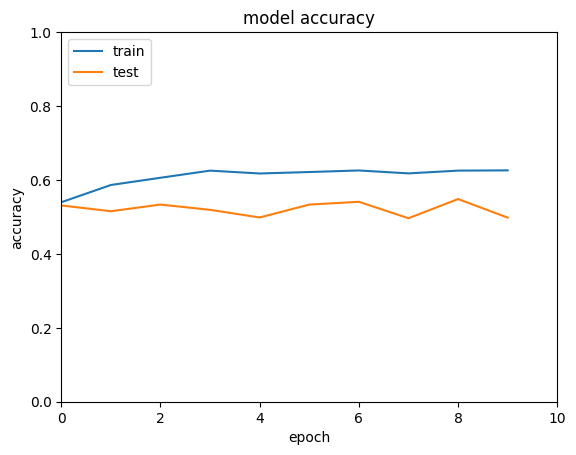

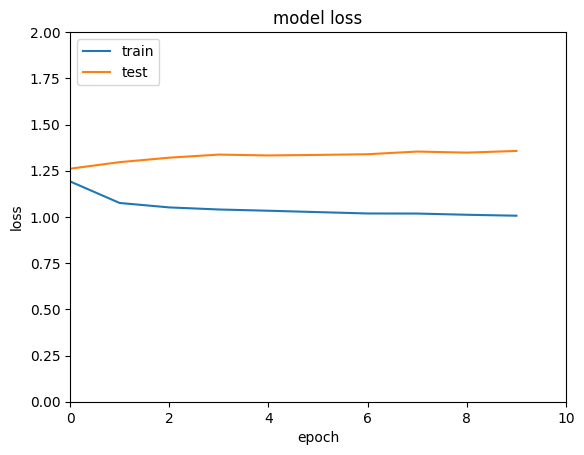

93/93 [==============================] - 0s 2ms/step


,walk,up,down,sit,stand,lay
walk,181,73,90,64,88,0
up,144,187,69,35,36,0
down,133,30,124,58,75,0
sit,26,20,8,378,59,0
stand,231,67,7,102,125,0
lay,0,53,0,11,0,473


In [18]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

The performance is poor.

### Stacked Simple RNNs

In [19]:
### START YOUR CODE

# stacked simpleRNN model
model = Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=(128, 9)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128, 32)           1344      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 3622 (14.15 KB)
Trainable params: 3622 (14.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
### START YOUR CODE
batch_size = 64
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
115/115 [==============================] - 29s 236ms/step - loss: 1.2191 - accuracy: 0.5249 - val_loss: 1.1230 - val_accuracy: 0.5541
Epoch 2/10
115/115 [==============================] - 33s 286ms/step - loss: 0.8205 - accuracy: 0.6542 - val_loss: 0.8884 - val_accuracy: 0.6379
Epoch 3/10
115/115 [==============================] - 25s 222ms/step - loss: 0.6825 - accuracy: 0.6991 - val_loss: 0.7988 - val_accuracy: 0.6647
Epoch 4/10
115/115 [==============================] - 25s 217ms/step - loss: 0.6308 - accuracy: 0.7171 - val_loss: 0.7741 - val_accuracy: 0.6885
Epoch 5/10
115/115 [==============================] - 26s 224ms/step - loss: 0.6424 - accuracy: 0.7244 - val_loss: 0.7475 - val_accuracy: 0.6977
Epoch 6/10
115/115 [==============================] - 26s 230ms/step - loss: 0.6036 - accuracy: 0.7354 - val_loss: 0.8873 - val_accuracy: 0.6532
Epoch 7/10
115/115 [==============================] - 26s 223ms/step - loss: 0.5321 - accuracy: 0.7705 - val_loss: 0.7212 - val_ac

Train accuracy (end): 0.815424382686615
Train accuracy (max): 0.815424382686615
Test accuracy (end) : 0.7543264627456665
Test accuracy (max) : 0.7543264627456665


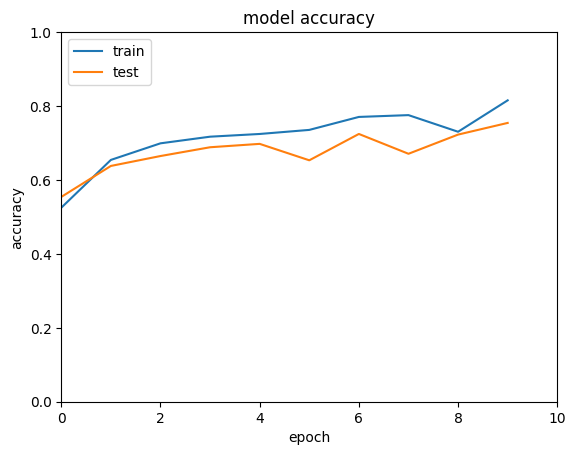

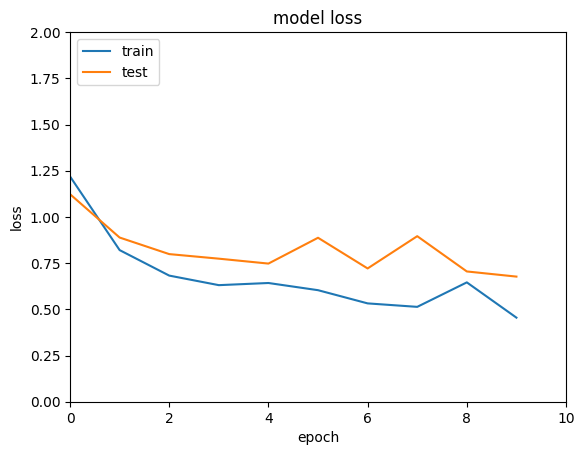

93/93 [==============================] - 3s 24ms/step


,walk,up,down,sit,stand,lay
walk,274,76,139,0,7,0
up,84,321,61,0,4,1
down,96,17,305,0,2,0
sit,18,0,0,373,100,0
stand,7,6,0,79,440,0
lay,0,27,0,0,0,510


In [21]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

The performance is significantly better than when using a single simpleRNN layer.

### Several CNN Layers

In [22]:
### START YOUR CODE

# Several CNN layers
model = Sequential([
    tf.keras.layers.Conv1D(16, 3, activation='relu', input_shape=(128, 9)),
    tf.keras.layers.Conv1D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
### END YOUR CODE

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 16)           448       
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 16)           784       
                                                                 
 max_pooling1d (MaxPooling1  (None, 62, 16)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 32)            1568      
                                                                 
 conv1d_3 (Conv1D)           (None, 58, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 29, 32)            0         
 g1D)                                                 

In [23]:
### START YOUR CODE
batch_size = 64
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
115/115 [==============================] - 5s 12ms/step - loss: 0.8219 - accuracy: 0.6753 - val_loss: 0.6188 - val_accuracy: 0.7421
Epoch 2/10
115/115 [==============================] - 1s 6ms/step - loss: 0.3221 - accuracy: 0.8781 - val_loss: 0.5298 - val_accuracy: 0.8161
Epoch 3/10
115/115 [==============================] - 1s 6ms/step - loss: 0.2226 - accuracy: 0.9210 - val_loss: 0.3819 - val_accuracy: 0.8728
Epoch 4/10
115/115 [==============================] - 1s 6ms/step - loss: 0.1654 - accuracy: 0.9366 - val_loss: 0.3312 - val_accuracy: 0.8826
Epoch 5/10
115/115 [==============================] - 1s 6ms/step - loss: 0.1430 - accuracy: 0.9423 - val_loss: 0.2997 - val_accuracy: 0.8924
Epoch 6/10
115/115 [==============================] - 1s 7ms/step - loss: 0.1300 - accuracy: 0.9486 - val_loss: 0.4095 - val_accuracy: 0.8629
Epoch 7/10
115/115 [==============================] - 1s 9ms/step - loss: 0.1289 - accuracy: 0.9491 - val_loss: 0.3205 - val_accuracy: 0.8911
Epoch

Train accuracy (end): 0.9567464590072632
Train accuracy (max): 0.9567464590072632
Test accuracy (end) : 0.8951476216316223
Test accuracy (max) : 0.8958262801170349


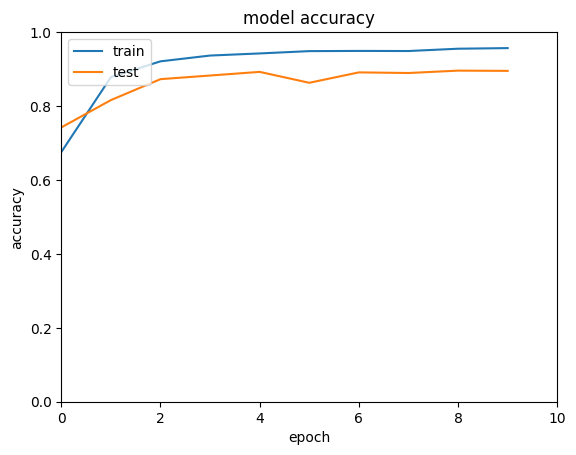

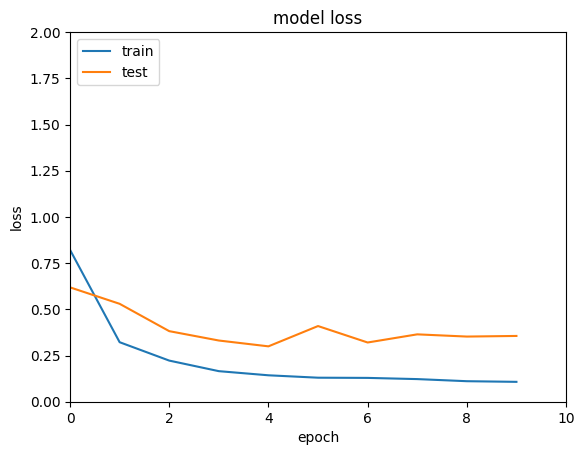

93/93 [==============================] - 0s 2ms/step


,walk,up,down,sit,stand,lay
walk,453,1,42,0,0,0
up,6,423,42,0,0,0
down,2,16,402,0,0,0
sit,0,8,0,382,101,0
stand,2,5,0,83,442,0
lay,0,1,0,0,0,536


In [24]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

This architecture provides the best performance until now. However, we could try using a more complex simpleRNN architecture to compare.

### More complex stacked RNN

In [38]:
### START YOUR CODE

# stacked simpleRNN model
model = Sequential([
    tf.keras.layers.SimpleRNN(128, return_sequences=True, input_shape=(128, 9)),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_22 (SimpleRNN)   (None, 128, 128)          17664     
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 6)                 774       
                                                                 
Total params: 51334 (200.52 KB)
Trainable params: 51334 (200.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
### START YOUR CODE
batch_size = 64
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
115/115 [==============================] - 33s 265ms/step - loss: 0.8554 - accuracy: 0.6447 - val_loss: 0.7582 - val_accuracy: 0.6454
Epoch 2/10
115/115 [==============================] - 37s 322ms/step - loss: 0.9218 - accuracy: 0.6489 - val_loss: 0.8219 - val_accuracy: 0.6719
Epoch 3/10
115/115 [==============================] - 26s 225ms/step - loss: 0.6216 - accuracy: 0.7620 - val_loss: 0.7501 - val_accuracy: 0.7309
Epoch 4/10
115/115 [==============================] - 27s 232ms/step - loss: 0.4775 - accuracy: 0.8230 - val_loss: 0.5898 - val_accuracy: 0.8018
Epoch 5/10
115/115 [==============================] - 28s 247ms/step - loss: 0.3924 - accuracy: 0.8588 - val_loss: 0.5390 - val_accuracy: 0.8324
Epoch 6/10
115/115 [==============================] - 30s 265ms/step - loss: 0.4717 - accuracy: 0.8309 - val_loss: 0.6045 - val_accuracy: 0.7774
Epoch 7/10
115/115 [==============================] - 30s 265ms/step - loss: 0.3715 - accuracy: 0.8693 - val_loss: 0.4686 - val_ac

Train accuracy (end): 0.9149891138076782
Train accuracy (max): 0.9149891138076782
Test accuracy (end) : 0.8771632313728333
Test accuracy (max) : 0.8771632313728333


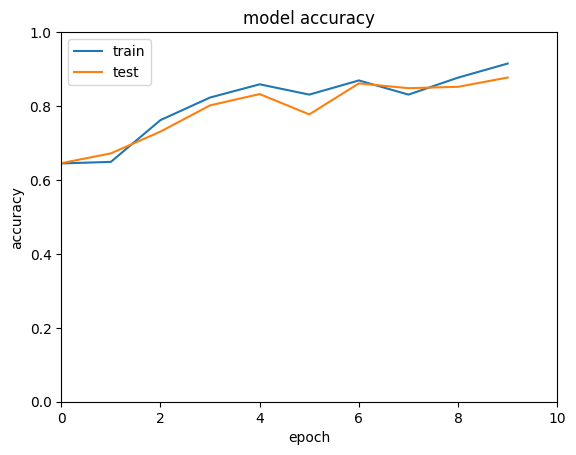

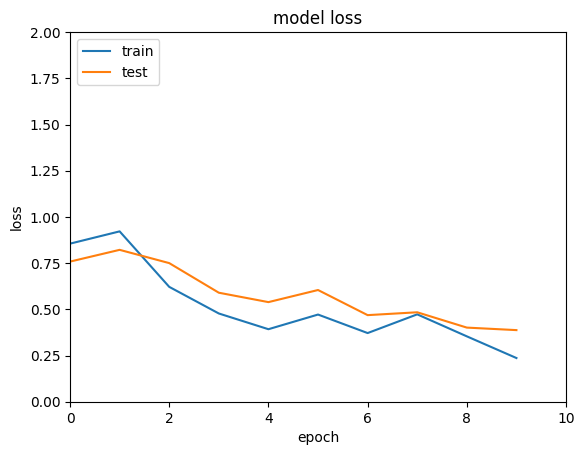

93/93 [==============================] - 2s 22ms/step


,walk,up,down,sit,stand,lay
walk,448,5,25,12,6,0
up,20,421,30,0,0,0
down,2,23,395,0,0,0
sit,0,3,0,378,110,0
stand,1,0,0,97,434,0
lay,0,27,0,1,0,509


In [40]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings
The model complexity could be increased without overfitting.

### Mixed CNN and RNN

In [28]:
### START YOUR CODE

# Mixed CNN and RNN model
model = Sequential([
    tf.keras.layers.Conv1D(16, 3, activation='relu', input_shape=(128, 9)),
    tf.keras.layers.Conv1D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 16)           448       
                                                                 
 conv1d_7 (Conv1D)           (None, 124, 16)           784       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 62, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 60, 32)            1568      
                                                                 
 conv1d_9 (Conv1D)           (None, 58, 32)            3104      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 29, 32)            0         
 g1D)                                                 

In [29]:
### START YOUR CODE
batch_size = 64
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
115/115 [==============================] - 6s 34ms/step - loss: 1.0476 - accuracy: 0.5571 - val_loss: 0.8095 - val_accuracy: 0.6111
Epoch 2/10
115/115 [==============================] - 7s 57ms/step - loss: 0.5927 - accuracy: 0.7360 - val_loss: 0.5643 - val_accuracy: 0.7594
Epoch 3/10
115/115 [==============================] - 4s 36ms/step - loss: 0.4268 - accuracy: 0.8105 - val_loss: 0.4844 - val_accuracy: 0.7754
Epoch 4/10
115/115 [==============================] - 4s 33ms/step - loss: 0.3398 - accuracy: 0.8414 - val_loss: 0.4552 - val_accuracy: 0.7981
Epoch 5/10
115/115 [==============================] - 6s 56ms/step - loss: 0.3148 - accuracy: 0.8638 - val_loss: 0.4230 - val_accuracy: 0.8256
Epoch 6/10
115/115 [==============================] - 4s 32ms/step - loss: 0.2696 - accuracy: 0.8905 - val_loss: 0.4070 - val_accuracy: 0.8395
Epoch 7/10
115/115 [==============================] - 4s 31ms/step - loss: 0.2301 - accuracy: 0.9106 - val_loss: 0.3660 - val_accuracy: 0.8575

Train accuracy (end): 0.9400163292884827
Train accuracy (max): 0.9400163292884827
Test accuracy (end) : 0.8931116461753845
Test accuracy (max) : 0.8931116461753845


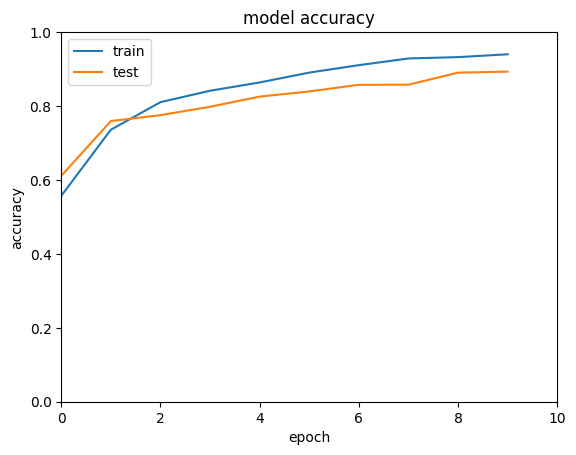

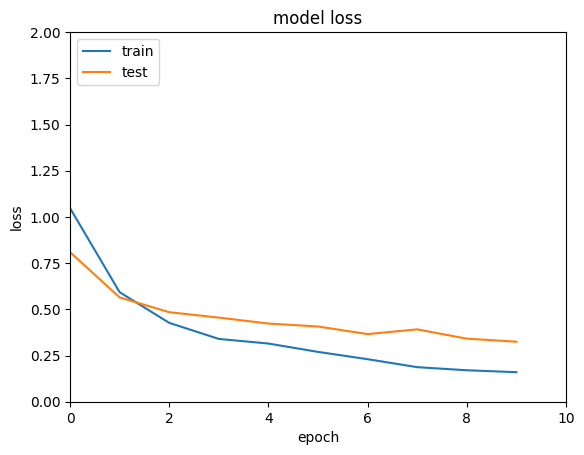

93/93 [==============================] - 1s 5ms/step


,walk,up,down,sit,stand,lay
walk,433,9,54,0,0,0
up,1,444,25,0,1,0
down,12,6,402,0,0,0
sit,0,25,0,403,63,0
stand,0,5,0,108,419,0
lay,0,6,0,0,0,531


In [30]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

Using CNN layers only provided similar results.

### Smaller batch size, higher number of epochs

In [41]:
### START YOUR CODE

# Mixed CNN and RNN model
model = Sequential([
    tf.keras.layers.Conv1D(16, 3, activation='relu', input_shape=(128, 9)),
    tf.keras.layers.Conv1D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 126, 16)           448       
                                                                 
 conv1d_11 (Conv1D)          (None, 124, 16)           784       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 62, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 60, 32)            1568      
                                                                 
 conv1d_13 (Conv1D)          (None, 58, 32)            3104      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 29, 32)            0         
 g1D)                                                

In [42]:
### START YOUR CODE
batch_size = 32
n_epochs   = 20

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/20
230/230 [==============================] - 15s 53ms/step - loss: 0.9092 - accuracy: 0.6098 - val_loss: 0.7553 - val_accuracy: 0.6620
Epoch 2/20
230/230 [==============================] - 12s 53ms/step - loss: 0.5126 - accuracy: 0.7831 - val_loss: 0.6366 - val_accuracy: 0.7180
Epoch 3/20
230/230 [==============================] - 10s 42ms/step - loss: 0.3724 - accuracy: 0.8509 - val_loss: 0.4440 - val_accuracy: 0.8602
Epoch 4/20
230/230 [==============================] - 7s 32ms/step - loss: 0.2249 - accuracy: 0.9226 - val_loss: 0.4628 - val_accuracy: 0.8371
Epoch 5/20
230/230 [==============================] - 9s 41ms/step - loss: 0.2104 - accuracy: 0.9256 - val_loss: 0.4248 - val_accuracy: 0.8694
Epoch 6/20
230/230 [==============================] - 7s 31ms/step - loss: 0.1546 - accuracy: 0.9419 - val_loss: 0.3110 - val_accuracy: 0.9023
Epoch 7/20
230/230 [==============================] - 10s 42ms/step - loss: 0.1288 - accuracy: 0.9497 - val_loss: 0.3434 - val_accuracy: 0.

Train accuracy (end): 0.9522578716278076
Train accuracy (max): 0.9555222988128662
Test accuracy (end) : 0.9083814024925232
Test accuracy (max) : 0.9155073165893555


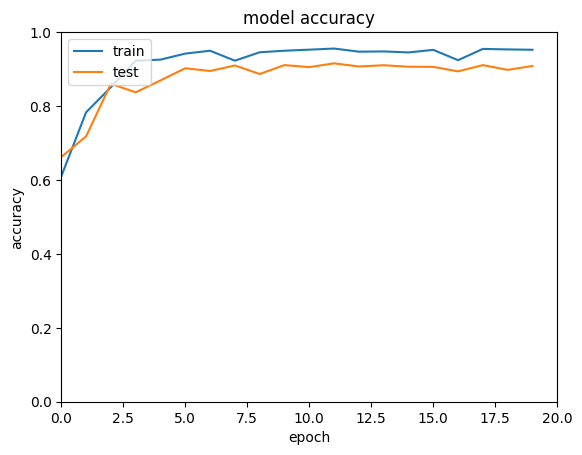

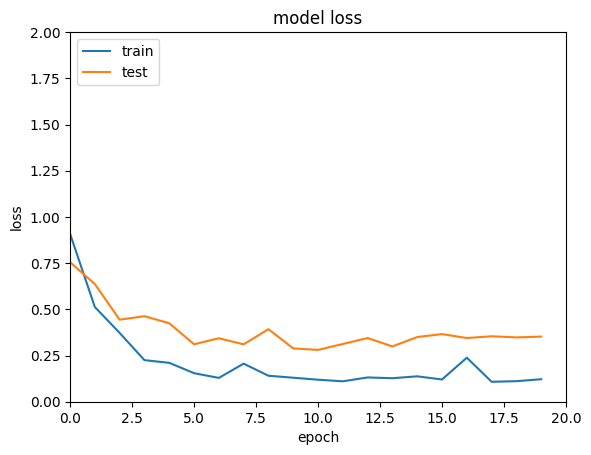

93/93 [==============================] - 1s 6ms/step


,walk,up,down,sit,stand,lay
walk,485,1,10,0,0,0
up,70,387,12,0,1,1
down,19,3,398,0,0,0
sit,0,2,0,411,57,21
stand,0,0,0,73,459,0
lay,0,0,0,0,0,537


In [43]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings
The model starts to overfit.